Notes:

* implement policy gradient method
* train step after episode
* training in script outside of colab (w/o rendering to save)
* use same arch: https://github.com/mswang12/Blog/blob/master/Completed_2020/REINFORCE_reimplementation/REINFORCE_reimplementation.py
* distributions: https://pytorch.org/docs/stable/distributions.html
* toy example: https://github.com/Finspire13/pytorch-policy-gradient-example/blob/master/pg.py
* https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

[ 0.19800236  0.80785595 -0.21102844 -1.31120308] 1.0 1


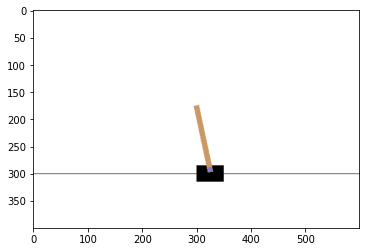

In [3]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(1000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print(obs, reward, action)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions 

class Agent(nn.Module):
    def __init__(self, state_shape, action_shape):
        super(Agent, self).__init__()
        self.state_shape = state_shape
        self.action_shape = action_shape

        self.relu = nn.ReLU(inplace=True)
        self.linear1 = nn.Linear(state_shape, 24)
        self.linear2 = nn.Linear(24, 12)
        self.linear3 = nn.Linear(12, action_shape)
        # self.softmax = nn.Softmax()

    def forward(self, state):
        # print(state, state.shape)
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        action = F.softmax(self.linear3(x))
        # action = self.linear3(x)
        
        return action

def one_hot_encode_action(action, n_actions):
    encoded = np.zeros(n_actions, np.float32)
    encoded[action] = 1
    return encoded

def get_discounted_rewards(rewards):
    """
    - The discounted rewards sum up all the rewards in the episode
    - Later rewards are exponentially less important
    """
    discounted_rewards = np.zeros(len(rewards))
    running_add = 0
    gamma = 0.99
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

# loss = nn.CrossEntropyLoss()
# loss = nn.NLLLoss()

In [5]:
agent = Agent(4, 2)
# agent.double() # Observation is double, so convert agent params to double

In [6]:
# Setup env.
SEED = 1 # 1337
env = gym.make("CartPole-v1")
env.reset()
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# setup model
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
model = Agent(n_states, n_actions)

# training settings.
n_episodes = 5000
episode_lengths = []
render = False

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# test_obs = env.reset()
# test_obs = test_obs.astype(np.float32)
# test_obs = torch.from_numpy(test_obs)
# test_obs = test_obs.reshape([1, test_obs.shape[0]])
running_reward = 10
for episode in range(1, n_episodes + 1):
    observation = env.reset()
    ep_reward = 0

    test_obs = observation.astype(np.float32)
    test_obs = torch.from_numpy(test_obs)
    test_obs = test_obs.reshape([1, test_obs.shape[0]])

    done = False

    observations = []
    actions = []
    rewards = []
    gradients = []
    probs = []
    log_probs = []

    # print(observation)

    t = 0
    while not done:
        if render:
            screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        
        # observation (4,) -> (1, 4)
        observation_reshaped = observation.reshape([1, observation.shape[0]])

        # 1. Get next action.
        obs_tmp = observation_reshaped.astype(np.float32)
        torch_obs = torch.from_numpy(obs_tmp)
        action_prob_distribution = model.forward(torch_obs)
        m = torch.distributions.Categorical(action_prob_distribution)
        action_prob_distribution = action_prob_distribution.flatten().detach().numpy()
        # action = np.random.choice(n_actions, 1, p=action_prob_distribution.flatten().detach().numpy())[0]
        # print(action)
        # action = np.zeros(n_actions)
        action = m.sample()
        observation, reward, done, info = env.step(action.item())
        ep_reward += reward

        # 2. Record history.
        observations.append(observation_reshaped)
        # encoded_action = one_hot_encode_action(action, n_actions)
        # actions.append(encoded_action)
        actions.append(action)
        rewards.append(reward)
        probs.append(action_prob_distribution)
        log_probs.append(m.log_prob(action))
        t += 1

        if done:
            # print('Episode finished after {} timesteps'.format(t))
            episode_lengths.append(t + 1)
            # print('Average Episode Length: {} from n_episodes: {}'.format(np.mean(episode_lengths), episode))
            # 3. Update policy
            discounted_rewards = get_discounted_rewards(rewards)
            # returns = torch.tensor(discounted_rewards)
            # discounted_rewards = (returns - returns.mean()) / (returns.std() + eps)
            discounted_rewards -= np.mean(discounted_rewards)
            discounted_rewards /= np.std(discounted_rewards + 1e-7)
            # print(rewards)
            discounted_rewards = torch.Tensor(discounted_rewards)
            # print(discounted_rewards)

            alpha = 1e-4
            # NOTE: This line is important!
            # The term "alpha * (encoded_action - action_probability_distribution) * discounted_rewards" is only a direction (gradient) and NOT the target value
            # It needs to be added to the original target action probabilities (action_probability_distribution) in order to create a target value for the model.train_on_batch() function
            actions = torch.Tensor(actions)
            # print(m.log_prob(actions))
            loss = [-log_prob * r for log_prob, r in zip(log_probs, discounted_rewards)]
            # loss = torch.cat(loss)
            # loss = -m.log_prob(actions) * discounted_rewards
            # print(loss)
            loss = torch.cat(loss).sum()
            # print(loss)

            # print(actions[0])
            # print(model(test_obs))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(model(test_obs))

            # model.train_on_batch(np.vstack(observations), gradients_with_advantage)
            observations = []
            actions = []
            rewards = []
            gradients = []
            probs = []
            log_probs = []
            break

    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    if episode % 10 == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                episode, ep_reward, running_reward))

# ipythondisplay.clear_output(wait=True)
env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 10	Last reward: 24.00	Average reward: 14.88
Episode 20	Last reward: 12.00	Average reward: 19.88
Episode 30	Last reward: 45.00	Average reward: 27.35
Episode 40	Last reward: 20.00	Average reward: 35.09
Episode 50	Last reward: 20.00	Average reward: 29.49
Episode 60	Last reward: 36.00	Average reward: 33.71
Episode 70	Last reward: 82.00	Average reward: 46.74
Episode 80	Last reward: 207.00	Average reward: 87.12
Episode 90	Last reward: 257.00	Average reward: 112.20
Episode 100	Last reward: 500.00	Average reward: 236.60
Episode 110	Last reward: 322.00	Average reward: 266.62
Episode 120	Last reward: 500.00	Average reward: 344.19
Episode 130	Last reward: 500.00	Average reward: 390.20
Episode 140	Last reward: 500.00	Average reward: 434.26
Episode 150	Last reward: 500.00	Average reward: 460.64
Episode 160	Last reward: 500.00	Average reward: 476.43
Episode 170	Last reward: 458.00	Average reward: 428.90
Episode 180	Last reward: 125.00	Average reward: 372.43
Episode 190	Last reward: 100.00	Av

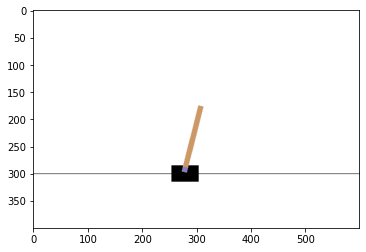

In [ ]:

env = gym.make("CartPole-v1")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(1000):
    # action = env.action_space.sample()
    action_prob_distribution = model.forward(torch_obs)
    m = torch.distributions.categorical.Categorical(action_prob_distribution)
    action = m.sample().detach().numpy()[0]
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()
print(i)
# print(obs, reward, action)
# print(action, action_prob_distribution, action1)


In [ ]:
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


args = {'gamma': 0.99, 'seed': 543, 'render': False, 'log-interval': 10}


env = gym.make('CartPole-v1')
env.seed(args['seed'])
torch.manual_seed(args['seed'])


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + args['gamma'] * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    print(returns)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def main():
    running_reward = 10
    for i_episode in range(5000):
    # for i_episode in count(1):
        state, ep_reward = env.reset(), 0
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            if args['render']:
                env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % args['log-interval'] == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
main()

Streaming output truncated to the last 5000 lines.
         5.7058e-01,  5.6823e-01,  5.6585e-01,  5.6345e-01,  5.6103e-01,
         5.5858e-01,  5.5610e-01,  5.5360e-01,  5.5108e-01,  5.4853e-01,
         5.4595e-01,  5.4335e-01,  5.4072e-01,  5.3807e-01,  5.3539e-01,
         5.3268e-01,  5.2994e-01,  5.2718e-01,  5.2439e-01,  5.2157e-01,
         5.1872e-01,  5.1585e-01,  5.1294e-01,  5.1001e-01,  5.0704e-01,
         5.0405e-01,  5.0102e-01,  4.9797e-01,  4.9488e-01,  4.9176e-01,
         4.8861e-01,  4.8543e-01,  4.8222e-01,  4.7898e-01,  4.7570e-01,
         4.7239e-01,  4.6904e-01,  4.6566e-01,  4.6225e-01,  4.5880e-01,
         4.5532e-01,  4.5180e-01,  4.4825e-01,  4.4466e-01,  4.4104e-01,
         4.3738e-01,  4.3368e-01,  4.2994e-01,  4.2617e-01,  4.2236e-01,
         4.1851e-01,  4.1462e-01,  4.1069e-01,  4.0672e-01,  4.0272e-01,
         3.9867e-01,  3.9458e-01,  3.9045e-01,  3.8628e-01,  3.8206e-01,
         3.7780e-01,  3.7350e-01,  3.6916e-01,  3.6477e-01,  3.6034e-01,
